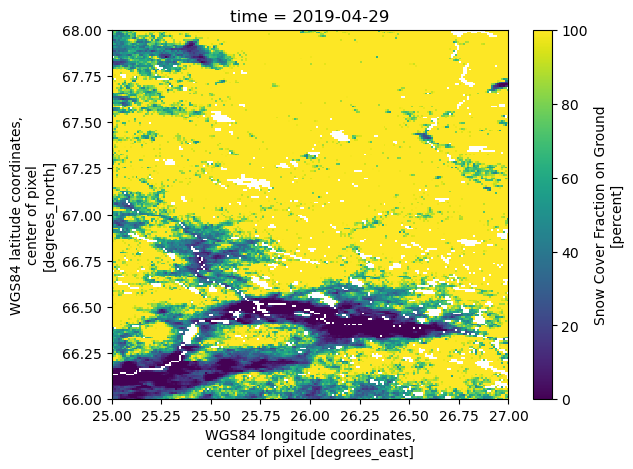

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

date = '29'

filename = f'../scratch/data/SCFG/dap.ceda.ac.uk/2019/04/201904{date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv3.0.nc'

# Open the NetCDF file using xarray
data = xr.open_dataset(filename)

plt.figure()

# data.sel(lat=slice(60,70), lon=slice(20,30))['scfg'].plot()

scfg_filtered = data.sel(lat=slice(66,68), lon=slice(25,27))['scfg']
scfg_filtered = scfg_filtered.where(scfg_filtered <= 100, np.nan)
scfg_filtered.plot()

# # Display the dataset
# # data.close()

# plt.figure()

# filename = f'../data_store/data/SCFG/dap.ceda.ac.uk/v2.0/2019/03/201903{date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'

# # Open the NetCDF file using xarray
# data = xr.open_dataset(filename)

# # data.sel(lat=slice(60,70), lon=slice(20,30))['scfg'].plot()

# scfg_filtered = data.sel(lat=slice(66,68), lon=slice(25,27))['scfg']
# scfg_filtered = scfg_filtered.where(scfg_filtered <= 100, np.nan)
# scfg_filtered.plot()

# # Display the dataset
# # data.close()

<xarray.Dataset> Size: 16GB
Dimensions:        (lat: 18000, nv: 2, lon: 36000, time: 1)
Coordinates:
  * time           (time) datetime64[ns] 8B 2019-04-29
  * lat            (lat) float64 144kB -90.0 -89.98 -89.97 ... 89.98 89.98 90.0
  * lon            (lon) float64 288kB -180.0 -180.0 -180.0 ... 180.0 180.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds       (lat, nv) float64 288kB ...
    lon_bnds       (lon, nv) float64 576kB ...
    scfg           (time, lat, lon) float32 3GB ...
    scfg_unc       (time, lat, lon) float32 3GB ...
    satzen         (time, lat, lon) float64 5GB ...
    scanline_time  (time, lat, lon) float64 5GB ...
    spatial_ref    int32 4B ...
Attributes: (12/42)
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                ENVEO IT GmbH
    source:                     TERRA MODIS, Collection 6.1: calibrated radia...
    history:                    2024-02-02: ESA snow_cci processing line SCFG...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                aa391fc0-48ec-43a7-8732-882f277fb36d
    ...                         ...
    license:                    ESA CCI Data Policy: free and open access
    platform:                   TERRA
    sensor:                     MODIS
    spatial_resolution:         0.01 degree
    key_variables:              scfg
    doi:                        10.5285/80567d38de3f4b038ee6e6e53ed1af8a

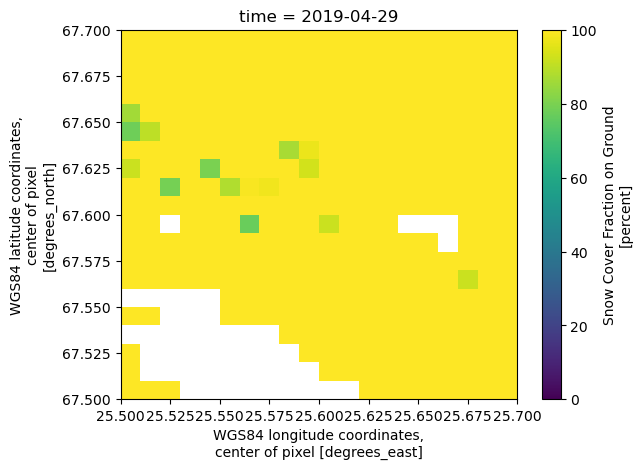

In [7]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

date = '29'

filename = f'../scratch/data/SCFG/dap.ceda.ac.uk/2019/04/201904{date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv3.0.nc'

# Open the NetCDF file using xarray
data = xr.open_dataset(filename)

plt.figure()

# data.sel(lat=slice(60,70), lon=slice(20,30))['scfg'].plot()

scfg_filtered = data.sel(lat=slice(67.5,67.7), lon=slice(25.5,25.7))['scfg']
scfg_filtered = scfg_filtered.where(scfg_filtered <= 100, np.nan)
scfg_filtered.plot(vmin=0, vmax=100)

# Display the dataset
# data.close()

# data.lat_bnds[:10].values
data

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define the latitude and longitude boundaries for the region of interest
lat_min, lat_max = 67.361833 - 1, 67.361833 + 1
lon_min, lon_max = 26.634154 - 1, 26.634154 + 1

# Select the subset of the data within the specified region
scfg_subset = data['scfg'].sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max)).isel(time=0)

# Set values greater than 100 (which represent flags) to NaN
scfg_subset_cleaned = scfg_subset.where(scfg_subset <= 100)

# # Plot the subset data with flag values set to NaN
# plt.figure(figsize=(10, 6))
# scfg_subset_cleaned.plot(cmap='viridis')
# plt.title(f'SCFG Data on 2018-10-01 for Sodankyla')
# plt.show()

# Define the exact latitude and longitude of interest
lat_val = 67.361833
lon_val = 26.634154

# Select the value at the specified latitude and longitude
scfg_value = scfg_subset_cleaned.sel(lat=lat_val, lon=lon_val, method='nearest').values

# Display the value
print(f"SCFG value at (lat={lat_val}, lon={lon_val}): {scfg_value}")

SCFG value at (lat=67.361833, lon=26.634154): nan


# SCFG data_array

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime
import os

df=pd.read_pickle('dataset.pkl')

values_1 = [[] for _ in range(6)]
values_3 = [[] for _ in range(6)]
values = [values_1, values_3]
radius = [1,3]
coords = [(26.634154, 67.361833), (-145.7514, 63.8811), (-93.4541, 47.5049), 
          (-71.6696, 46.9521), (7.5609, 45.8238), (-121.606, 44.3238)]

start_date = '01/10/2018'
end_date = '31/12/2022'

# Convert strings to datetime objects
start = datetime.strptime(start_date, '%d/%m/%Y')
end = datetime.strptime(end_date, '%d/%m/%Y')

# Generate the array of dates
date_array = [(start + pd.Timedelta(days=i)).strftime('%Y%m%d') 
              for i in range((end - start).days + 1)]

def compute_scfg_value(scfg_data, coord, radius_km=2, threshold=100, default_value=200):
    """
    Compute the SCFG value as the average of values ≤ threshold within a radius_km,
    or set to default_value if all values exceed the threshold.

    Parameters:
        scfg_data (xarray.DataArray): The dataset with SCFG values and spatial dimensions (lat, lon).
        coord (tuple): The coordinate as (lon, lat) for which the value is computed.
        radius_km (float): The radius in kilometers to search around the given coordinate (default: 2).
        threshold (float): The maximum value to include in the average (default: 100).
        default_value (float): The value to assign if all values exceed the threshold (default: 200).

    Returns:
        float: The computed SCFG value.
    """
    # Unpack coordinates
    lon, lat = coord

    # Convert radius from kilometers to degrees
    radius_deg_lat = radius_km / 111.0  # 1 degree latitude ≈ 111 km
    radius_deg_lon = radius_km / (111.0 * np.cos(np.radians(lat)))  # Adjust for latitude

    # Subset the data within the radius
    subset = scfg_data.sel(
        lat=slice(lat - radius_deg_lat, lat + radius_deg_lat),
        lon=slice(lon - radius_deg_lon, lon + radius_deg_lon)
    )

    # Mask values greater than the threshold
    valid_values = subset.where(subset <= threshold, drop=True)

    # Calculate the average or assign the default value
    if valid_values.size > 0:  # If there are valid values
        return valid_values.mean().item()
    else:  # If all values exceed the threshold
        return default_value

for j, date in enumerate(date_array):
    # print(date)
    year = date[:4]
    month = date[4:6]

    file_path = f'../scratch/data/SCFG/dap.ceda.ac.uk/{year}/{month}/{date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv3.0.nc'

    # if not os.path.exists(file_path):
    #     print('No')
    #     for i, coord in enumerate(coords):
            

    try:
        dataset = xr.open_dataset(file_path)
    except Exception as e:
        print(f"Failed to open {file_path}: {e}")
        for i in range(len(coords)):
            for A in values:
                if j != 0:
                    A[i].append(A[i][-1])
                else:
                    A[i].append(np.nan)
        continue
    scfg_data = dataset['scfg']

    for i, coord in enumerate(coords):
        for p, A in enumerate(values):
            scfg_value = compute_scfg_value(scfg_data, coord, radius_km=radius[p])
    
            if j == 0:
                if scfg_value <= 100:
                    A[i].append(scfg_value)
                else:
                    A[i].append(np.nan)
            else:
                if scfg_value <= 100:
                    A[i].append(scfg_value)
                else:
                    A[i].append(A[i][-1])

date_array = [datetime.strptime(date, '%Y%m%d') for date in date_array]
# values

Failed to open ../data_store/data/SCFG/dap.ceda.ac.uk/2018/12/20181205-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc: [Errno 2] No such file or directory: '/home/s1803229/data_store/data/SCFG/dap.ceda.ac.uk/2018/12/20181205-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv2.0.nc'


In [24]:
# start_date = '2018-10-01'
# end_date = '2020-12-31'
# date_array = pd.date_range(start=start_date, end=end_date, freq='D').to_pydatetime().tolist()

# 2019

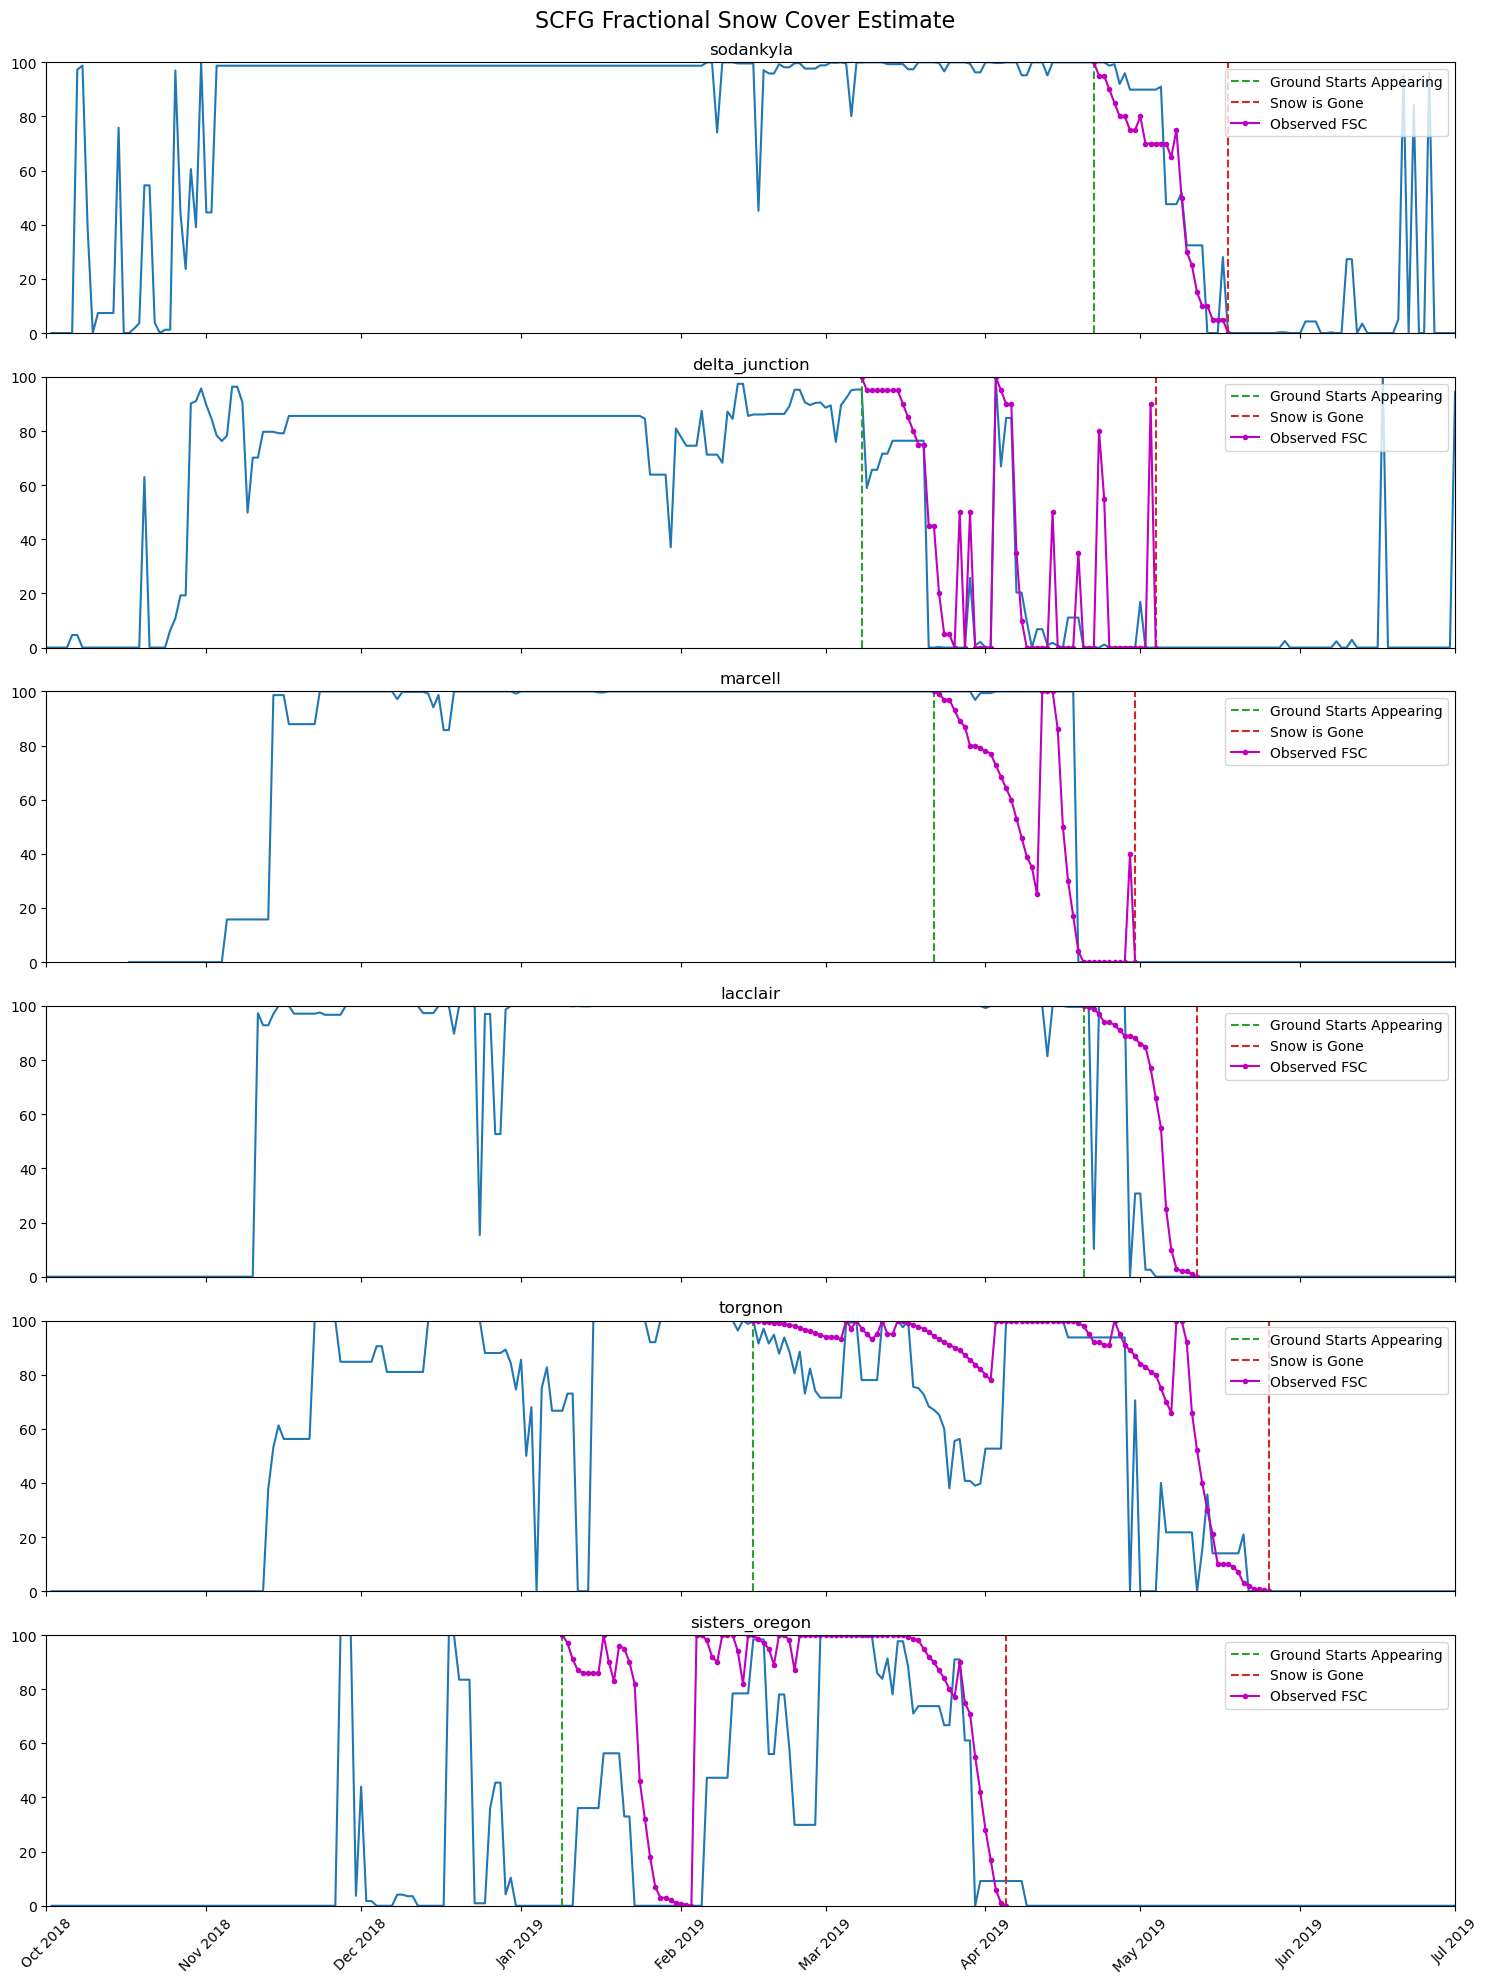

In [16]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

labels = ['sodankyla', 'delta_junction', 'marcell', 'lacclair', 'torgnon', 'sisters_oregon']
first_lines = [datetime.strptime('20190422', '%Y%m%d'),
               datetime.strptime('20190318', '%Y%m%d'),
               datetime.strptime('20190322', '%Y%m%d'),
               datetime.strptime('20190420', '%Y%m%d'),
               datetime.strptime('20190216', '%Y%m%d'),
               datetime.strptime('20190317', '%Y%m%d')]
second_lines = [datetime.strptime('20190518', '%Y%m%d'),
                datetime.strptime('20190326', '%Y%m%d'),
                datetime.strptime('20190420', '%Y%m%d'),
                datetime.strptime('20190512', '%Y%m%d'),
                datetime.strptime('20190526', '%Y%m%d'),
                datetime.strptime('20190405', '%Y%m%d')]

# Create subplots: 6 rows, 1 column
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 20), sharex=True)

# Formatting the x-axis limits
start_limit = datetime.strptime('20181001', '%Y%m%d')  
end_limit = datetime.strptime('20190701', '%Y%m%d')  

camera_snow_data = pd.read_excel("snow_timeline.xlsx")

locations = ['Sodankyla', 'Delta Junction', 'Marcell', 'Lacclair', 'Torgnon', 'Sisters']

for i, ax in enumerate(axes):
    # Plot data for each site
    if i == 4:
        ax.plot(date_array, values_1[i], color='tab:blue') #, label=labels[i]
    else:
        ax.plot(date_array, values_3[i], color='tab:blue') #, label=labels[i]
    
    # Add dashed vertical lines
    # ax.axvline(first_lines[i], color='tab:green', linestyle='--', linewidth=1.5, label='Melt Starts')
    # ax.axvline(second_lines[i], color='tab:red', linestyle='--', linewidth=1.5, label='Melt Ends')

    sodankyla_data = camera_snow_data[(camera_snow_data['Location'] == locations[i]) & 
                                      (camera_snow_data['Melt Year'] == 2019)]
    sod_obs = sodankyla_data['FSC'].values.tolist()
    sod_dates = pd.to_datetime(sodankyla_data['Date']).tolist()

    ax.axvline(sod_dates[0], color='tab:green', linestyle='--', linewidth=1.5, label='Ground Starts Appearing')
    ax.axvline(sod_dates[-1], color='tab:red', linestyle='--', linewidth=1.5, label='Snow is Gone')
    
    axes[i].plot(sod_dates, sod_obs, 'm.-', label='Observed FSC')

    # Formatting each subplot
    ax.set_title(labels[i])  # Title for each subplot
    ax.set_ylim(0, 100)  # Set the y-axis limits
    ax.set_xlim([start_limit, end_limit])  # Set the x-axis limits
    ax.legend(loc='upper right')  # Add legend to each subplot
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks on the first of each month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as Month-Year

# Rotate tick labels for shared x-axis
plt.xticks(rotation=45)

# Set the main title and adjust layout
fig.suptitle('SCFG Fractional Snow Cover Estimate', fontsize=16, y=.99)
plt.tight_layout()
plt.show()


# 2020

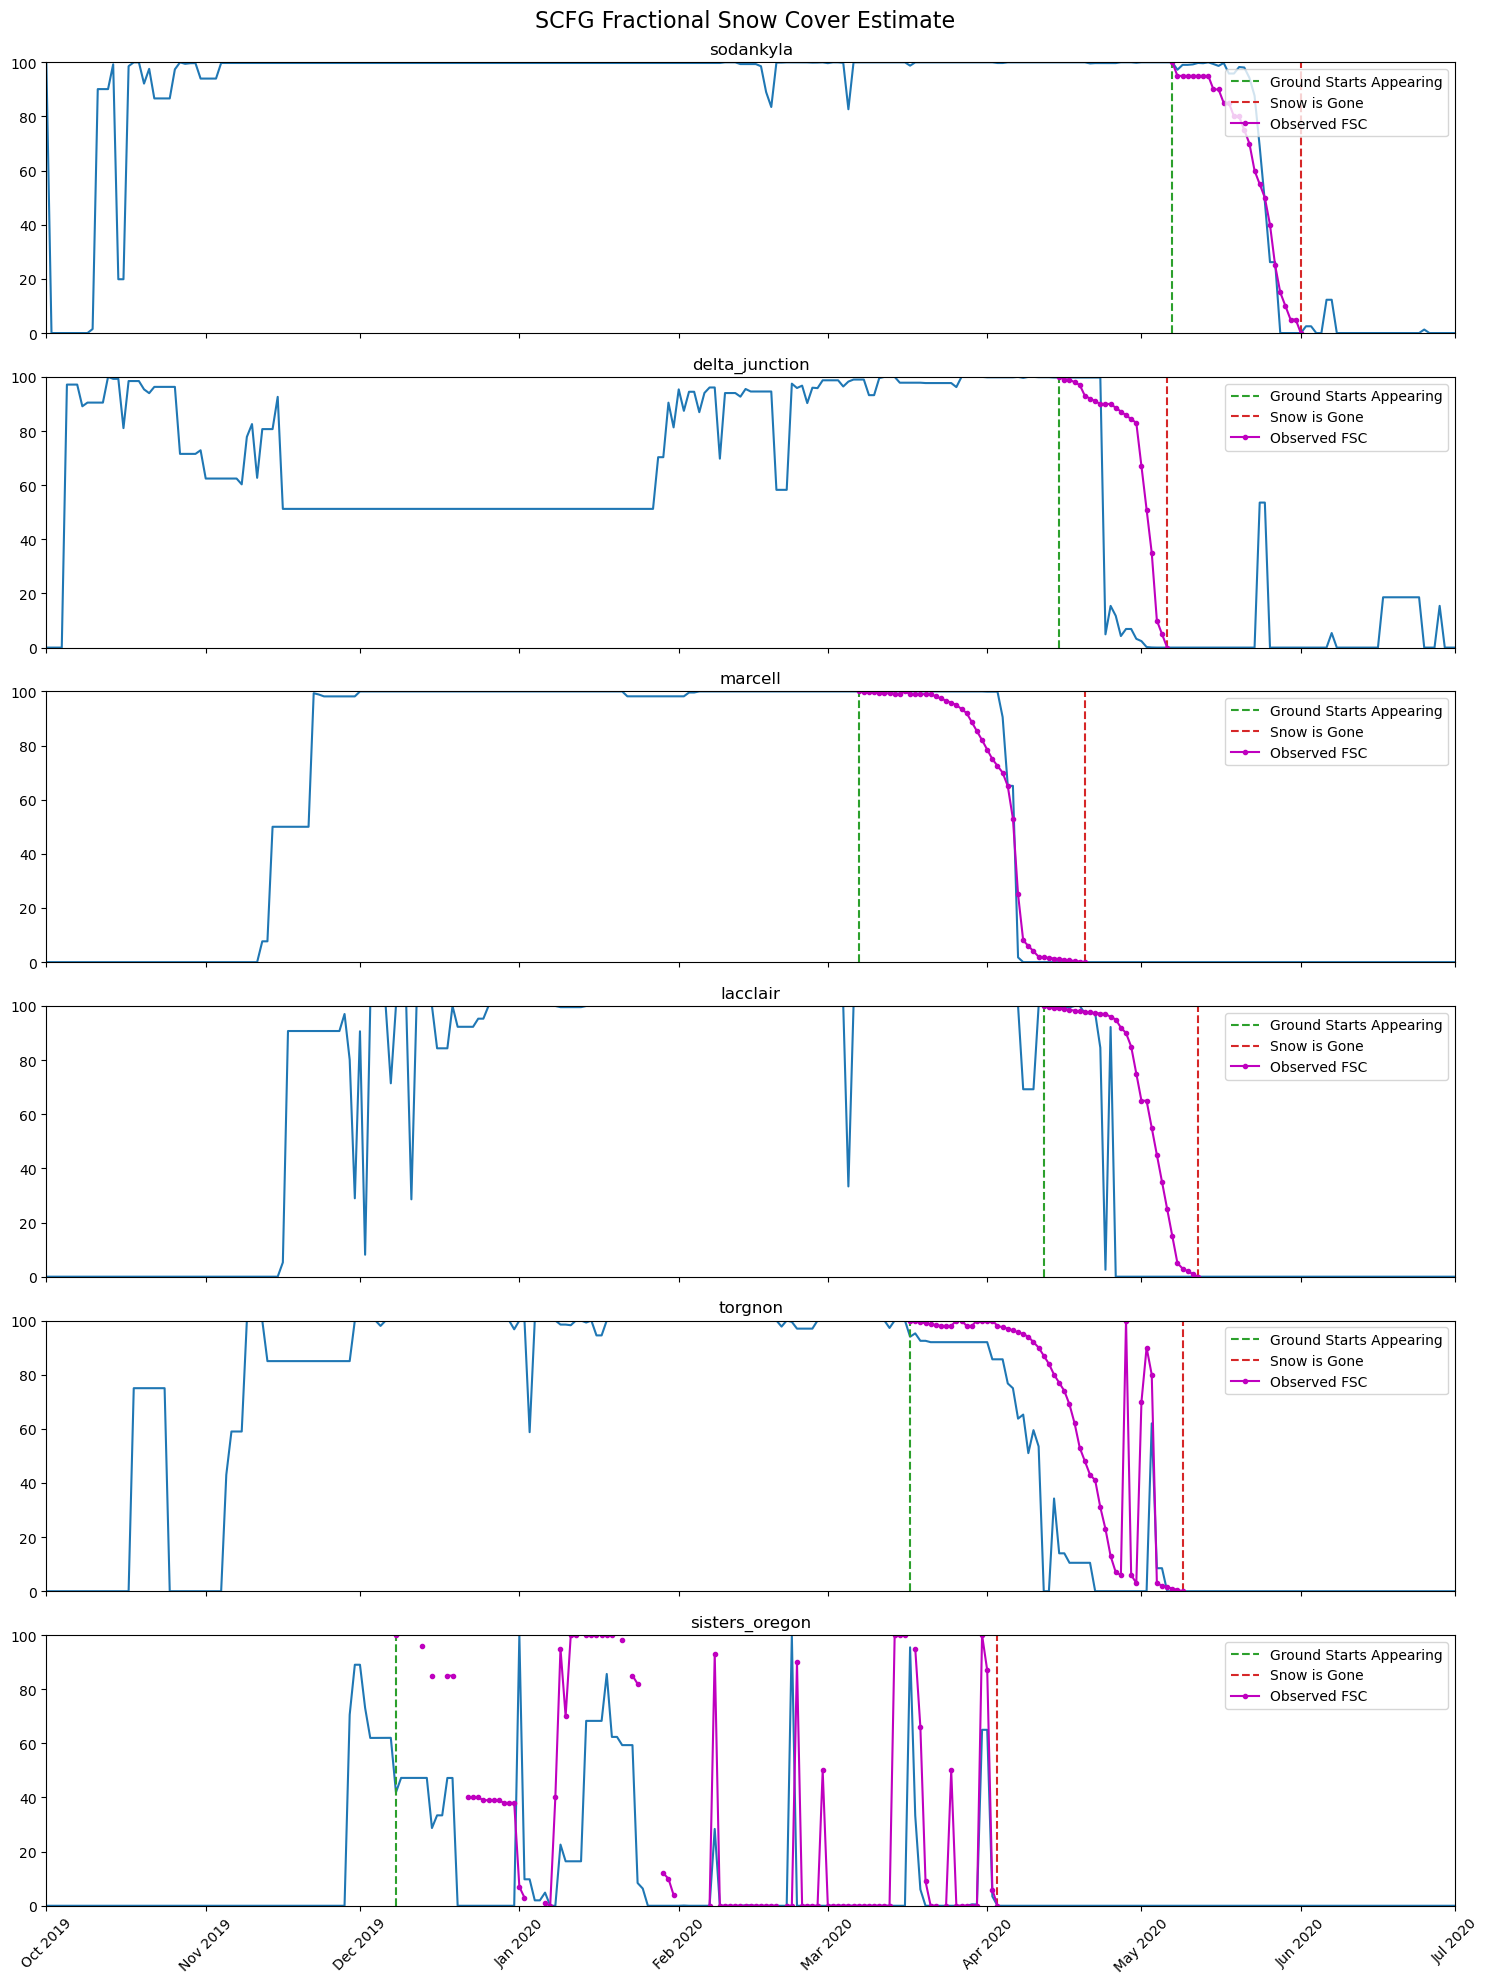

In [2]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
labels = ['sodankyla', 'delta_junction', 'marcell', 'lacclair', 'torgnon', 'sisters_oregon']
first_lines = [datetime.strptime('20200509', '%Y%m%d'),
              datetime.strptime('20200416', '%Y%m%d'),
              datetime.strptime('20200327', '%Y%m%d'),
              datetime.strptime('20200411', '%Y%m%d'),
              datetime.strptime('20200402', '%Y%m%d'),
              datetime.strptime('20191211', '%Y%m%d')]
second_lines = [datetime.strptime('20200603', '%Y%m%d'),
               datetime.strptime('20200507', '%Y%m%d'),
               datetime.strptime('20200412', '%Y%m%d'),
               datetime.strptime('20200511', '%Y%m%d'),
               datetime.strptime('20200508', '%Y%m%d'),
               datetime.strptime('20200201', '%Y%m%d')]

# Create subplots: 6 rows, 1 column
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(15, 20), sharex=True)

# Formatting the x-axis limits
start_limit = datetime.strptime('20191001', '%Y%m%d')  
end_limit = datetime.strptime('20200701', '%Y%m%d')    

camera_snow_data = pd.read_excel("snow_timeline.xlsx")

locations = ['Sodankyla', 'Delta Junction', 'Marcell', 'Lacclair', 'Torgnon', 'Sisters']

for i, ax in enumerate(axes):
    # Plot data for each site
    if i == 4:
        ax.plot(date_array, values_1[i], color='tab:blue') #, label=labels[i]
    else:
        ax.plot(date_array, values_3[i], color='tab:blue') #, label=labels[i]
    
    # Add dashed vertical lines
    # ax.axvline(first_lines[i], color='tab:green', linestyle='--', linewidth=1.5, label='Melt Starts')
    # ax.axvline(second_lines[i], color='tab:red', linestyle='--', linewidth=1.5, label='Melt Ends')

    sodankyla_data = camera_snow_data[(camera_snow_data['Location'] == locations[i]) & 
                                      (camera_snow_data['Melt Year'] == 2020)]
    sod_obs = sodankyla_data['FSC'].values.tolist()
    sod_dates = pd.to_datetime(sodankyla_data['Date']).tolist()

    ax.axvline(sod_dates[0], color='tab:green', linestyle='--', linewidth=1.5, label='Ground Starts Appearing')
    ax.axvline(sod_dates[-1], color='tab:red', linestyle='--', linewidth=1.5, label='Snow is Gone')
    
    axes[i].plot(sod_dates, sod_obs, 'm.-', label='Observed FSC')

    # Formatting each subplot
    ax.set_title(labels[i])  # Title for each subplot
    ax.set_ylim(0, 100)  # Set the y-axis limits
    ax.set_xlim([start_limit, end_limit])  # Set the x-axis limits
    ax.legend(loc='upper right')  # Add legend to each subplot
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Major ticks on the first of each month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format ticks as Month-Year

# Rotate tick labels for shared x-axis
plt.xticks(rotation=45)

# Set the main title and adjust layout
fig.suptitle('SCFG Fractional Snow Cover Estimate', fontsize=16, y=.99)
plt.tight_layout()
plt.show()

# Validation

# SCFG put into df

In [2]:
from scripts.imports import *
# df=pd.read_pickle('dataset_landcover_forest_22.pkl')
df=pd.read_pickle('work_in_progress.pkl')
df.columns

Index(['Camera', 'x_coord', 'y_coord', 'Date', 'Snow', 'SCFG', 'lon', 'lat',
       'landcover', 'forest_fraction', 'cc'],
      dtype='object')

In [24]:
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime
import os
import psutil

# df=pd.read_pickle('dataset_landcover_forest_22.pkl')

df['SCFG'] = None
# df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

def compute_scfg_value(scfg_data, coord, radius_km=2, threshold=100, default_value=200):
    """
    Compute the SCFG value as the average of values ≤ threshold within a radius_km,
    or set to default_value if all values exceed the threshold.

    Parameters:
        scfg_data (xarray.DataArray): The dataset with SCFG values and spatial dimensions (lat, lon).
        coord (tuple): The coordinate as (lon, lat) for which the value is computed.
        radius_km (float): The radius in kilometers to search around the given coordinate (default: 2).
        threshold (float): The maximum value to include in the average (default: 100).
        default_value (float): The value to assign if all values exceed the threshold (default: 200).

    Returns:
        float: The computed SCFG value.
    """
    # Unpack coordinates
    lon, lat = coord

    # Convert radius from kilometers to degrees
    radius_deg_lat = radius_km / 111.0  # 1 degree latitude ≈ 111 km
    radius_deg_lon = radius_km / (111.0 * np.cos(np.radians(lat)))  # Adjust for latitude

    # Subset the data within the radius
    subset = scfg_data.sel(
        lat=slice(lat - radius_deg_lat, lat + radius_deg_lat),
        lon=slice(lon - radius_deg_lon, lon + radius_deg_lon)
    )

    # Mask values greater than the threshold
    valid_values = subset.where(subset <= threshold, drop=True)

    # Calculate the average or assign the default value
    if valid_values.size > 0:  # If there are valid values
        return valid_values.mean().item()
    else:  # If all values exceed the threshold
        return default_value

print(df['date'].unique().shape[0])
for i in range(df['date'].unique().shape[0]):
    print(i)
    print(df['date'].unique()[i])
    
    # Function to convert date string from 'dd/mm/yyyy' to 'yyyymmdd'
    def format_date_to_filename(date_str):
        return datetime.strptime(date_str, '%d/%m/%Y').strftime('%Y%m%d')
    
    file_date = format_date_to_filename(df['date'].unique()[i])
    year = file_date[:4]
    month = file_date[4:6]
    file_path = f'../data_store/data/SCFG/dap.ceda.ac.uk/{year}/{month}/{file_date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv3.0.nc'
    
    if not os.path.exists(file_path):
        print('No')
    
    else:
        dataset = xr.open_dataset(file_path)
        scfv_data = dataset['scfg']
        
        for index, row in df.iterrows():
            if row['date'] == df['date'].unique()[i]:
                if row['camera'] == 'torgnon':
                    r = 1
                else:
                    r = 3
                # scfv_value = compute_scfg_value(scfv_data, coord = (row['lon'],row['lat']), radius_km=r)
                scfv_value_array = scfv_data.sel(lat=row['lat'], lon=row['long'], method='nearest').isel(time=0).values
                scfv_value = scfv_value_array.item() if isinstance(scfv_value_array, np.ndarray) else scfv_value_array
                if scfv_value > 100:
                    df.loc[index, 'SCFG'] = None
                else:
                    df.loc[index, 'SCFG'] = scfv_value
                # print(type(scfg_value))

    print(f"Memory usage: {psutil.Process(os.getpid()).memory_info().rss / (1024 ** 3):.2f} GB")
    
    print(df[df['date'] == df['date'].unique()[i]]['SCFG'])
# df.to_pickle('dataset_scfg.pkl')

# df[df['date'] == df['date'].unique()[i]]['SCFG']

153
0
12/01/2019
Memory usage: 0.38 GB
0     None
1     None
2     None
3     None
4     None
      ... 
58    None
59    None
60    None
61    None
62    None
Name: SCFG, Length: 63, dtype: object
1
24/01/2019
Memory usage: 0.40 GB
63     None
64     None
65     None
66     None
67     None
       ... 
277    None
278    None
279    None
280    None
281    None
Name: SCFG, Length: 219, dtype: object
2
27/03/2019
Memory usage: 0.39 GB
282    None
283    None
284    None
285    None
286    None
       ... 
436    None
437    None
438    None
439    None
440    None
Name: SCFG, Length: 159, dtype: object
3
13/04/2019
Memory usage: 0.41 GB
441    None
442    None
443    None
444    None
445    None
446    None
447    None
448    None
449    None
450    None
451    None
452    None
453    None
454    None
455    None
456    None
457    None
458    None
459    None
460    None
461    None
462    None
463    None
464    None
465    None
466    None
467    None
468    None
469    None
470    

In [25]:
# df.to_pickle('dataset_landcover_forest_22_SCFG.pkl')

# SCFG accuracy from dataframe

In [11]:
# df_grouped = df.groupby(['camera','date','lat','lon']).agg({
#     'pvpg': 'mean',
#     'pv': 'max',
#     'pg': 'max',
#     'data_quantity': 'mean',
#     'snr': 'mean',
#     'FSC': 'mean',
#     'TreeSnow': 'mean',
#     'layer_flag': 'mean',
#     'file_index': 'mean',
#     'msw_flag': 'mean',
#     # 'pv_ratio': 'mean',
#     'pv_ratio_mean': 'mean',
#     'pv_ratio_max': 'mean'
# }).reset_index()

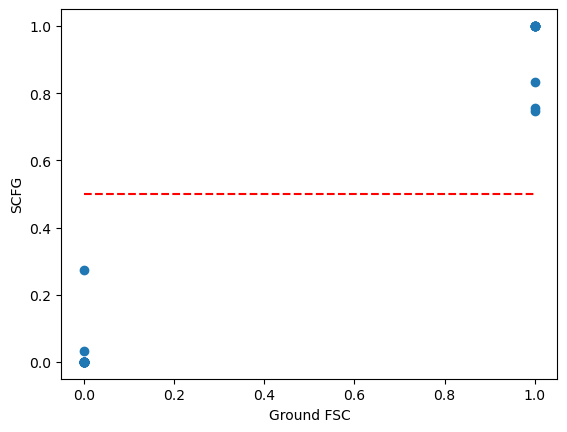

In [4]:
from scripts.imports import *

df=pd.read_pickle('dataset_landcover_all_22_th1_SCFG.pkl')

###
#len(df), len(df[df['segment_landcover'].isin([111,112,113,114,115,116,121,122,123,124,125,126])])
###

df_grouped = df[((df['FSC']<= 0.05)|(df['FSC']>=0.95))&(df['segment_landcover'].isin([111,112,113,114,115,116,121,122,123,124,125,126]))].groupby(['camera','date','lat','lon']).agg({
    'SCFG': 'mean',
    'FSC': 'mean'
}).reset_index()
df_grouped
plt.scatter(df_grouped['FSC'], df_grouped['SCFG'])
plt.xlabel('Ground FSC')
plt.ylabel('SCFG')
plt.plot([0,1],[0.5,0.5], 'r--')

# df_grouped[(df_grouped['SCFG'] > 80)&(df_grouped['FSC'] == 0)]
# df[df['SCFG']<=1]

#### includes SCFG data up to 2022

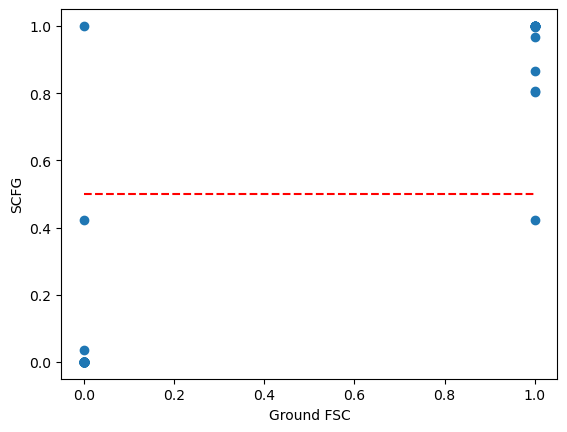

In [3]:
from scripts.imports import *

# includes SCFG data up to 2022
df=pd.read_pickle('dataset_landcover_forest_22_th1_SCFG.pkl')

###
#len(df), len(df[df['segment_landcover'].isin([111,112,113,114,115,116,121,122,123,124,125,126])])
###

df_grouped = df[((df['FSC']<= 0.05)|(df['FSC']>=0.95))&(df['segment_landcover'].isin([111,112,113,114,115,116,121,122,123,124,125,126]))].groupby(['camera','date','lat','lon']).agg({
    'SCFG': 'mean',
    'FSC': 'mean'
}).reset_index()
df_grouped
plt.scatter(df_grouped['FSC'], df_grouped['SCFG'])
plt.xlabel('Ground FSC')
plt.ylabel('SCFG')
plt.plot([0,1],[0.5,0.5], 'r--')

# df_grouped[(df_grouped['SCFG'] > 80)&(df_grouped['FSC'] == 0)]
# df[df['SCFG']<=1]

# SCFG accuracy from excel

In [1]:
from scripts.imports import *

df = pd.read_excel('SCFG_binary.xlsx')
df

,Camera,x_coord,y_coord,Date,Snow
0,sodankyla,26.634154,67.361833,2019-01-01,1
1,sodankyla,26.634154,67.361833,2019-01-02,1
2,sodankyla,26.634154,67.361833,2019-01-03,1
3,sodankyla,26.634154,67.361833,2019-01-04,1
4,sodankyla,26.634154,67.361833,2019-01-05,1
...,...,...,...,...,...
4056,oregon,-121.606000,44.323800,2020-12-10,0
4057,oregon,-121.606000,44.323800,2020-12-13,1
4058,oregon,-121.606000,44.323800,2020-12-19,0
4059,oregon,-121.606000,44.323800,2020-12-20,0


### turn excel into SCFG df

In [117]:
from scripts.imports import *

df = pd.read_excel('SCFG_binary.xlsx')

# temp_df = df.iloc[63:66].copy()
# temp_df = df.iloc[3000:3010].copy()
temp_df = df.copy()

temp_df.loc[:, 'SCFG'] = None
temp_df.loc[:, 'lon'] = None
temp_df.loc[:, 'lat'] = None
# df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

def compute_scfg_value(dataset, coord, radius_km=4, threshold=100, default_value=None):
    """
    Compute the SCFG value as the average of values ≤ threshold within a radius_km,
    or set to default_value if all values exceed the threshold.

    Parameters:
        scfg_data (xarray.DataArray): The dataset with SCFG values and spatial dimensions (lat, lon).
        coord (tuple): The coordinate as (lon, lat) for which the value is computed.
        radius_km (float): The radius in kilometers to search around the given coordinate (default: 2).
        threshold (float): The maximum value to include in the average (default: 100).
        default_value (float): The value to assign if all values exceed the threshold (default: 200).

    Returns:
        float: The computed SCFG value.
    """
    # Unpack coordinates
    lon, lat = coord

    scfg_data = dataset['scfg']

    # Convert radius from kilometers to degrees
    radius_deg_lat = radius_km / 111.0  # 1 degree latitude ≈ 111 km
    radius_deg_lon = radius_km / (111.0 * np.cos(np.radians(lat)))  # Adjust for latitude

    # Subset the data within the radius
    subset = dataset.sel(
        lat=slice(lat - radius_deg_lat, lat + radius_deg_lat),
        lon=slice(lon - radius_deg_lon, lon + radius_deg_lon)
    )

    valid_values = subset['scfg'].where(subset['scfg'] <= threshold)
    lons = subset['lon']
    lats = subset['lat']

    lon_grid,lat_grid = np.meshgrid(lons, lats)
    
    # valid_values = proxy['scfg']
    # print(valid_values)
    # Calculate the average or assign the default value
    if valid_values.size > 0:  # If there are valid values
        # plt.figure()
        # valid_values.plot(vmin=0, vmax=100)
        # print(valid_values.values.flatten())
        return valid_values.values.flatten()/100, lon_grid.flatten(), lat_grid.flatten()
    else:  # If all values exceed the threshold
        return [default_value], [default_value], [default_value]

#print(temp_df['Date'].unique().shape[0])
for i in range(temp_df['Date'].unique().shape[0]):
    #print(i)
    #print(temp_df['Date'].unique()[i])
    
    # Function to convert date string from 'dd/mm/yyyy' to 'yyyymmdd'
    def format_date_to_filename(date_str):
        if isinstance(date_str, pd.Timestamp):
            date_str = date_str.strftime("%Y-%m-%d")
        return datetime.strptime(date_str, "%Y-%m-%d").strftime("%Y%m%d")
    
    file_date = format_date_to_filename(temp_df['Date'].unique()[i])
    year = file_date[:4]
    month = file_date[4:6]
    file_path = f'../data_store/data/SCFG/dap.ceda.ac.uk/{year}/{month}/{file_date}-ESACCI-L3C_SNOW-SCFG-MODIS_TERRA-fv3.0.nc'
    
    if not os.path.exists(file_path):
        print('No')
    
    else:
        dataset = xr.open_dataset(file_path)
        
        for index, row in temp_df.iterrows():
            if row['Date'] == temp_df['Date'].unique()[i]:
                if row['Camera'] == 'torgnon':
                    r = 1
                else:
                    r = 4
                scfv_value, lon_grid, lat_grid = compute_scfg_value(dataset, coord = (row['x_coord'],row['y_coord']), radius_km=r)
                # scfv_value_array = scfv_data.sel(lat=row['latitude'], lon=row['longitude'], method='nearest').isel(time=0).values
                # scfv_value = scfv_value_array.item() if isinstance(scfv_value_array, np.ndarray) else scfv_value_array
                temp_df.at[index, 'SCFG'], temp_df.at[index, 'lon'], temp_df.at[index, 'lat'] = scfv_value, lon_grid, lat_grid
                # print(type(scfg_value))

    #print(f"Memory usage: {psutil.Process(os.getpid()).memory_info().rss / (1024 ** 3):.2f} GB")
temp_df = temp_df.explode(['SCFG', 'lon', 'lat']).reset_index(drop=True)
temp_df
# print(temp_df.explode('SCFG').reset_index(drop=True))
    # print(temp_df[temp_df['Date'] == temp_df['Date'].unique()[i]]['SCFG'])
    # print(scfv_value.flatten())

,Camera,x_coord,y_coord,Date,Snow,SCFG,lon,lat
0,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.545,67.335
1,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.555,67.335
2,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.565,67.335
3,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.575,67.335
4,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.585,67.335
...,...,...,...,...,...,...,...,...
316343,oregon,-121.606000,44.323800,2020-12-21,0,NaN,-121.605,44.355
316344,oregon,-121.606000,44.323800,2020-12-21,0,NaN,-121.595,44.355
316345,oregon,-121.606000,44.323800,2020-12-21,0,0.0,-121.585,44.355
316346,oregon,-121.606000,44.323800,2020-12-21,0,0.0,-121.575,44.355


In [120]:
# temp_df.to_pickle('SCFG_accuracy.pkl')

In [16]:
from scripts.imports import *
df = pd.read_pickle('SCFG_accuracy.pkl')
df

,Camera,x_coord,y_coord,Date,Snow,SCFG,lon,lat
0,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.545,67.335
1,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.555,67.335
2,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.565,67.335
3,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.575,67.335
4,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.585,67.335
...,...,...,...,...,...,...,...,...
316343,oregon,-121.606000,44.323800,2020-12-21,0,NaN,-121.605,44.355
316344,oregon,-121.606000,44.323800,2020-12-21,0,NaN,-121.595,44.355
316345,oregon,-121.606000,44.323800,2020-12-21,0,0.0,-121.585,44.355
316346,oregon,-121.606000,44.323800,2020-12-21,0,0.0,-121.575,44.355


### work out how landcover maps work

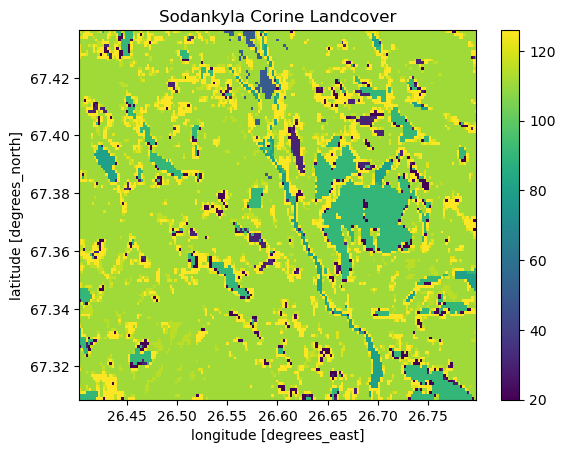

In [8]:
from scripts.imports import *
import rioxarray

tif_path = '../data_store/data/corine_sodankyla/Results/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif'

ds = rioxarray.open_rasterio(tif_path)

ds = ds.rio.reproject("EPSG:4326")

ds.sel(band=1).plot()
plt.title("Sodankyla Corine Landcover")

plt.plot([7.5609],[45.8238],'r.')
plt.show()

# with rasterio.open(tif_path) as dataset:
#     # Read the first band
#     band1 = dataset.read(1)

#     # Get metadata
#     meta = dataset.meta

# with rasterio.open(corine_sod) as dataset:
#     print("Width:", dataset.width)
#     print("Height:", dataset.height)
#     print("Number of bands:", dataset.count)
#     print("Coordinate Reference System (CRS):", dataset.crs)
#     print("Bounds:", dataset.bounds)
#     print("Transform:", dataset.transform)

# plt.imshow(band1, cmap="gray")
# plt.colorbar(label="Pixel Values")
# plt.title("Raster Image")
# plt.show()

### insert landcover information into SCFG dataframe

In [5]:
from scripts.imports import *
df = pd.read_pickle('SCFG_accuracy.pkl')

test = df.copy()
test['landcover'] = None
test['forest_fraction'] = None
for index, row in test.iterrows():
    tif_path = f"../data_store/data/corine_{row['Camera']}/Results/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
    ds = rioxarray.open_rasterio(tif_path)
    ds = ds.rio.reproject("EPSG:4326")

    meter_to_degree_lat = 1 / 111320
    meter_to_degree_lon = meter_to_degree_lat / np.cos(np.radians(row['lat']))

    delta_lat = (1000 / 2) * meter_to_degree_lat
    delta_lon = (1000 / 2) * meter_to_degree_lon

    subset = ds.sel(
        x=slice(row['lon'] - delta_lon, row['lon'] + delta_lon),
        y=slice(row['lat'] + delta_lat, row['lat'] - delta_lat),  # Latitude decreases downward
        band=1
    )

    values = subset.values.flatten()
    values = values[~np.isnan(values)]

    if len(values) == 0:
        test.at[index, 'forest'], test.at[index, 'landcover'] = None

    else:
        count_in_range = np.sum((values >= 111) & (values <= 126))
        fraction = count_in_range / len(values)
        test.at[index, 'forest_fraction'] = fraction
        test.at[index, 'landcover'] = mode(values)[0]

test

,Camera,x_coord,y_coord,Date,Snow,SCFG,lon,lat,landcover,forest_fraction
0,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.545,67.335,111,0.956522
1,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.555,67.335,111,0.927536
2,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.565,67.335,111,0.898551
3,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.575,67.335,111,0.888889
4,sodankyla,26.634154,67.361833,2019-01-01,1,NaN,26.585,67.335,111,0.89372
...,...,...,...,...,...,...,...,...,...,...
316343,oregon,-121.606000,44.323800,2020-12-21,0,NaN,-121.605,44.355,111,1.0
316344,oregon,-121.606000,44.323800,2020-12-21,0,NaN,-121.595,44.355,111,1.0
316345,oregon,-121.606000,44.323800,2020-12-21,0,0.0,-121.585,44.355,111,1.0
316346,oregon,-121.606000,44.323800,2020-12-21,0,0.0,-121.575,44.355,111,1.0


In [6]:
# test.to_pickle('SCFG_accuracy_w_forest_frac.pkl')

316348
118076
75087


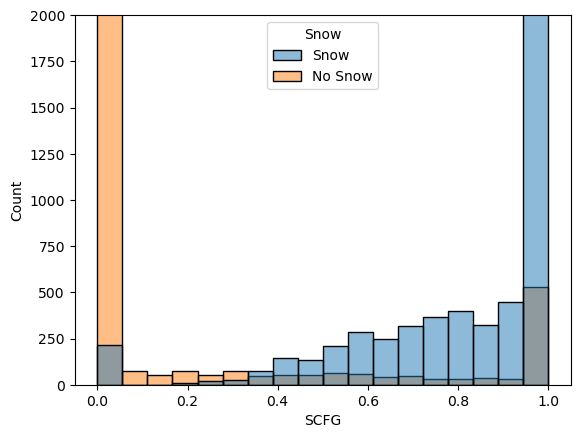

In [8]:
from scripts.imports import *
df = pd.read_pickle('SCFG_accuracy_w_forest_frac.pkl')
print(len(df))
print(len(df[df['SCFG'] <= 1]))
print(len(df[(df['SCFG'] <= 1)&(df['forest_fraction'] >= .95)]))
temp_df = df[(df['SCFG'] <= 1)&(df['forest_fraction'] >= .95)].copy()

plt.figure()
# plt.scatter(temp_df['Snow'], temp_df['SCFG'])
# plt.xlabel('Snow Observation')
# plt.ylabel('SCFG Estimate')
temp_df['Snow'] = temp_df['Snow'].map({0: 'No Snow', 1: 'Snow'}).copy()
sns.histplot(data=temp_df, x='SCFG', hue='Snow')
plt.ylim(0,2000)
plt.show()

In [27]:
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# # Copy data
# data = temp_df.copy()

# # Define threshold search space
# thresholds = np.linspace(0, 1, 101)  # 101 values from 0 to 1
# best_threshold = 0.5
# best_f1 = 0

# # Search for best threshold
# for t in thresholds:
#     data['classification'] = data['SCFG'].apply(lambda x: 0 if x <= t else 1)
#     f1 = f1_score(data['Snow'], data['classification'], average='weighted')
    
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = t

# # Apply best threshold
# data['classification'] = data['SCFG'].apply(lambda x: 0 if x <= best_threshold else 1)

# # Compute confusion matrix
# labels = ['No Snow', 'Snow']
# cm = confusion_matrix(data['Snow'], data['classification'])

# # Calculate accuracy and F1-score
# accuracy = accuracy_score(data['Snow'], data['classification'])
# f1 = f1_score(data['Snow'], data['classification'], average='weighted')

# # Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
# plt.tight_layout()
# plt.show()

# # Print best threshold
# print(f'Best threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.2f}')

# # Identify misclassified cases
# misclassified = data[((data['classification'] == 0) & (data['Snow'] > 0.95)) |
#                      ((data['classification'] == 1) & (data['Snow'] < 0.05))]
# misclassified[misclassified['Camera']=='sodankyla']


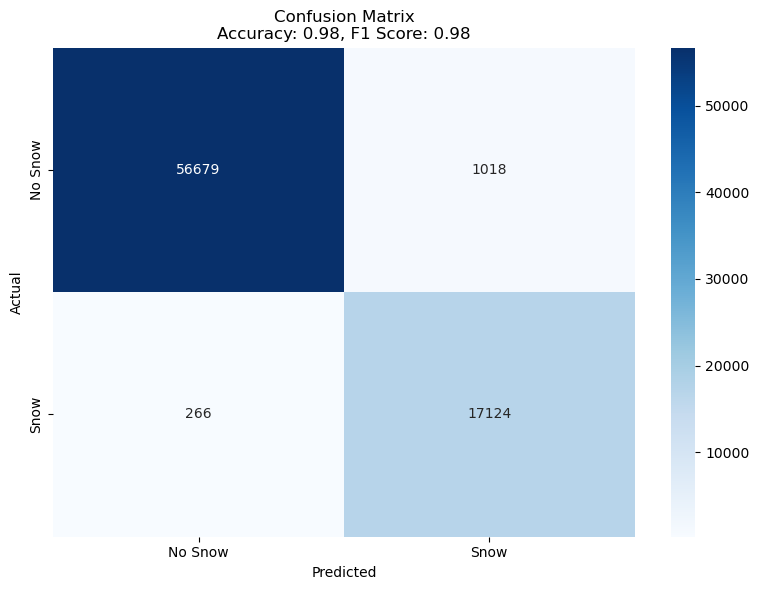

123

In [28]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

data = temp_df.copy()

data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (1 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 0 if row['SCFG'] <= 0.34 else (1),
    axis=1
)

# data.loc[:, 'FSC'] = round(data['FSC'])#.astype(int)

# Compute confusion matrix
labels = ['No Snow', 'Snow']
cm = confusion_matrix(data['Snow'], data['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data['Snow'], data['classification'])
f1 = f1_score(data['Snow'], data['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
misclassified = data[((data['classification']==0)&(data['Snow']>.95))|((data['classification']==1)&(data['Snow']<.05))]
len(misclassified[misclassified['Camera']=='oregon'])

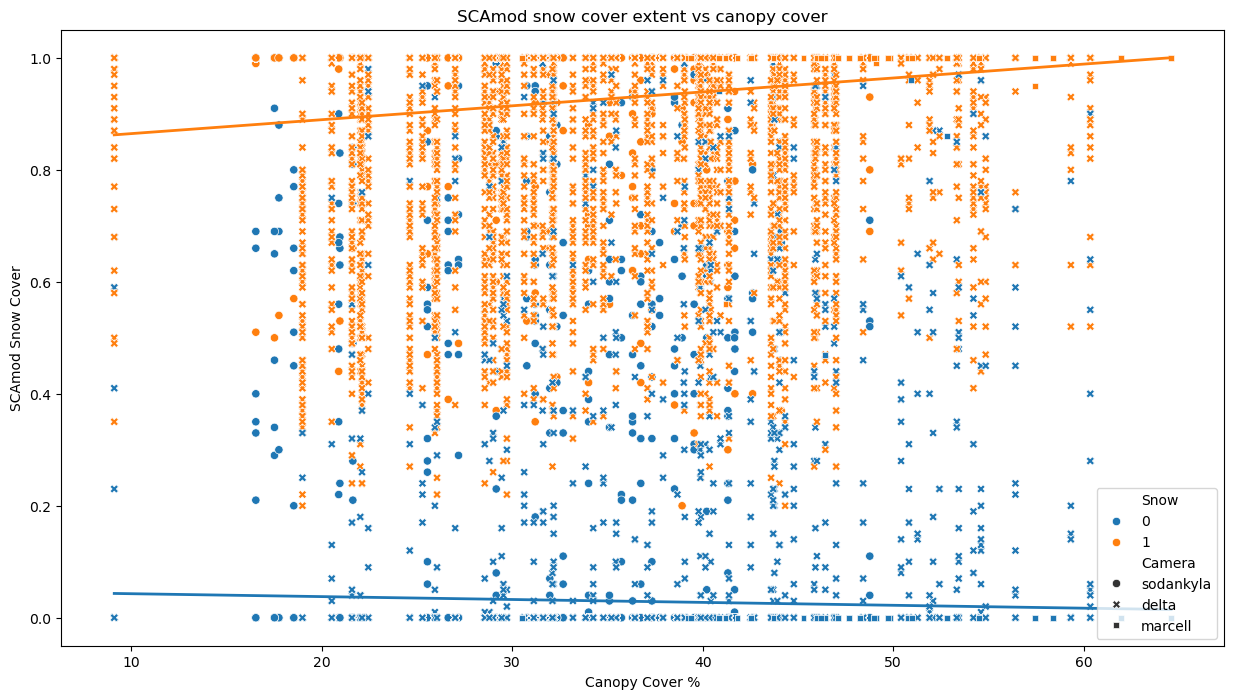

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_pickle('work_in_progress.pkl')

plt.figure(figsize=(15, 8))
colors = ['blue', 'orange']

for i in [0,1]:
    loc_df = df[(df['cc'] >= 0)&(df['Snow']==i)&(df['forest_fraction']>=.95)].copy().reset_index()
    
    X = loc_df['cc'].astype(float).values  # Canopy Cover %
    y = loc_df['SCFG'].astype(float).values
    
    mask = np.isfinite(X) & np.isfinite(y)
    X = X[mask].reshape(-1, 1)
    y = y[mask]
    
    X_with_const = sm.add_constant(X)
    
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    
    slope = results.params[1]
    p_value = results.pvalues[1]
    
    x_vals = np.linspace(X.min(), X.max(), 100)
    y_vals = results.predict(sm.add_constant(x_vals.reshape(-1, 1)))
    # plt.plot(x_vals, y_vals, color=colors[i-1], linewidth=2, label=f'Best Fit {labels[i-1]}')
    plt.plot(x_vals, y_vals, linewidth=2)

loc_df = df[(df['cc'] >= 0)&(df['forest_fraction']>=.95)].copy().reset_index()
scatter = sns.scatterplot(data=loc_df, x='cc', y='SCFG', hue='Snow', style='Camera',palette='tab10', legend='brief')

# Update the legend labels
hue_labels = {'0.0': 'No Snow', '1.0': 'Snow'}  # Note keys are strings for exact matching
handles, labels = scatter.get_legend_handles_labels()

# Update legend labels based on the hue_labels dictionary
new_labels = [hue_labels.get(label, label) for label in labels]

plt.legend(handles=handles, labels=new_labels, loc='lower right')

# Customize and show the plot
plt.xlabel('Canopy Cover %')
plt.ylabel('SCAmod Snow Cover')

plt.title('SCAmod snow cover extent vs canopy cover')

plt.show()